In [1]:
import pandas as pd
import sklearn
import numpy as np
from random import sample
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.pipeline import make_pipeline

In [2]:
def gen_true_data(x, sigma=0.1):
    mu = np.sin(1/5*x)
    y = np.random.normal(mu, scale = sigma)
    return y

test data generator

Text(0.5, 0, 'input, X')

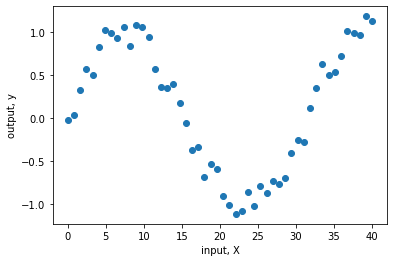

In [3]:
X = np.linspace(0, 40, num=50)
y = gen_true_data(X)
X = X.reshape(-1, 1)
plt.plot(X,y,'o')
plt.ylabel('output, y')
plt.xlabel('input, X')

In [4]:
def random_sampler(X, prev_sampled_ix, N=1):
    """
    X is design matrix (1-D vector) containing all possible points in X domain
    prev_sampled_ix is the indices sampled X points
    N is number of points we want to sample next
    """
    remaining_ix= list(set(np.arange(X.size)) - set(prev_sampled_ix))

    if len(X)-len(prev_sampled_ix)-N <0:
        print("warning: attempting to sample "+str(abs(len(X)-len(prev_sampled_ix)-N))+" more samples than there are available.")
        
    new_ix = []    
    for n in range(1,N+1):
        if len(remaining_set)==0:
            return new_ix
        new_ix += list(np.random.choice(remaining_ix,1, replace=False))
        remaining_ix = list(set(remaining_ix) - set(new_ix))

    return new_ix
    

In [5]:
def GP_sampler(X, y, prev_idx):
    
    scaler = StandardScaler()
    scaler.fit(X[prev_idx])
    
    alpha = 1E-3
    length_scale = 0.5 
    nu = 1 #RBF kernel

    gp = GaussianProcessRegressor(alpha=alpha,
                                  kernel=Matern(length_scale=length_scale, nu=nu),
                                  normalize_y=True, 
                                  random_state=42
                                 )
    gp.fit(scaler.transform(X[prev_idx]), y[prev_idx])
        
    pred, pred_std = gp.predict(scaler.transform(X), return_std=True)
    
    
    return np.argmax(pred_std), gp, scaler


initial sampled indices: [9, 15, 16, 26, 29, 32, 35, 38, 46, 48]
initial sampled X's: [ 7.34693878 12.24489796 13.06122449 21.2244898  23.67346939 26.12244898
 28.57142857 31.02040816 37.55102041 39.18367347]


/Users/brian/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/brian/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/brian/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https:/

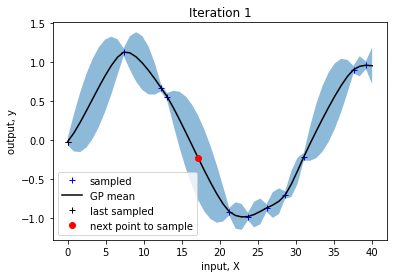

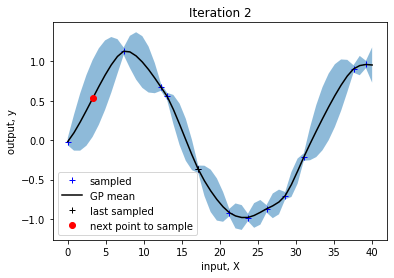

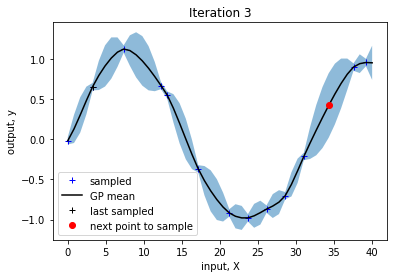

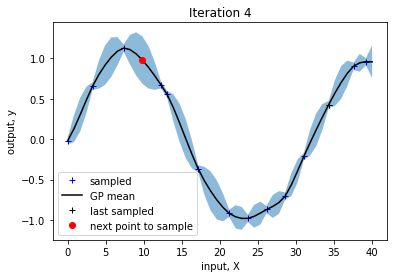

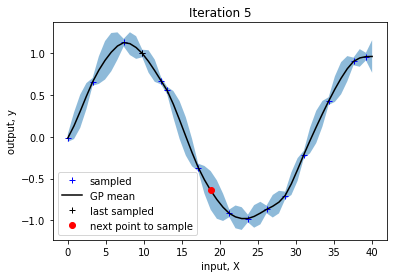

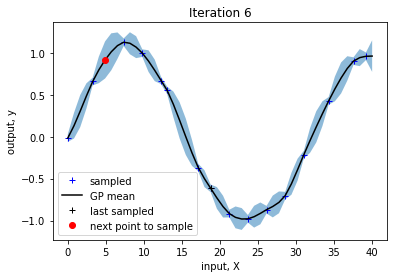

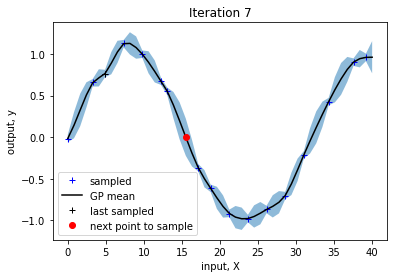

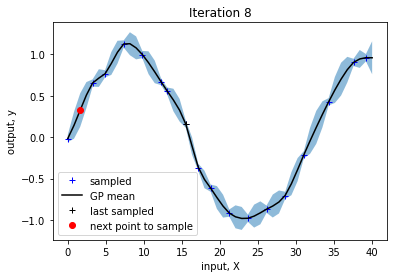

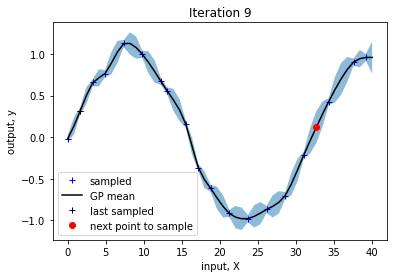

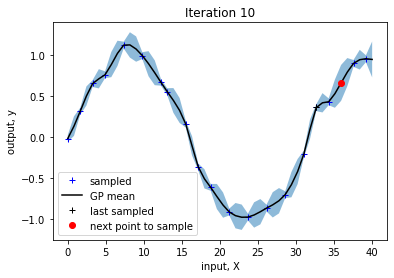

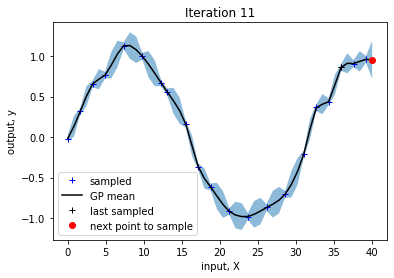

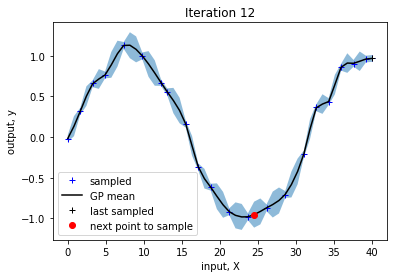

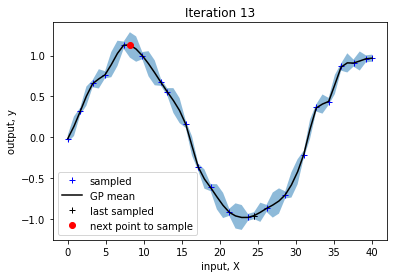

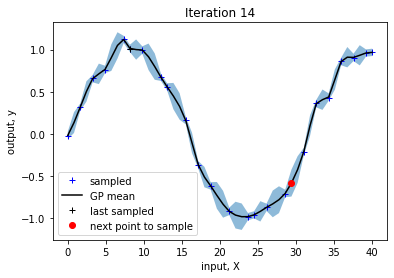

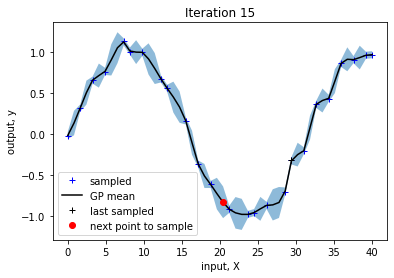

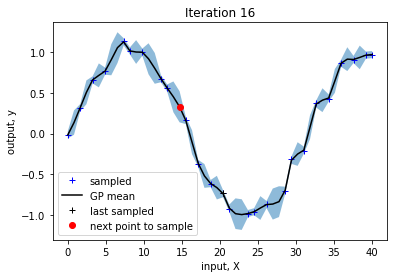

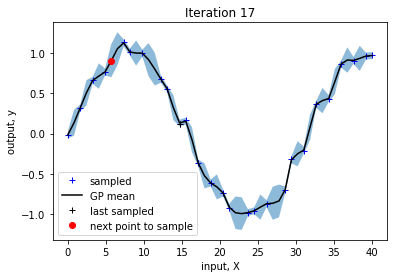

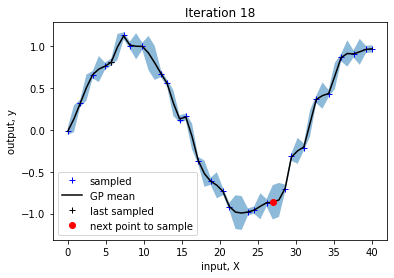

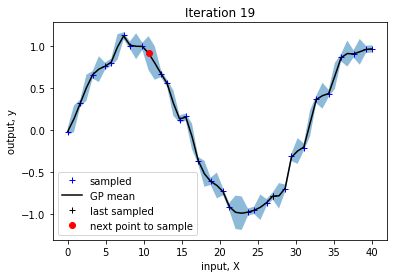

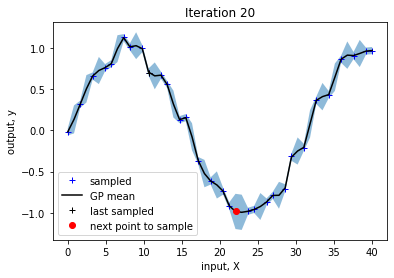

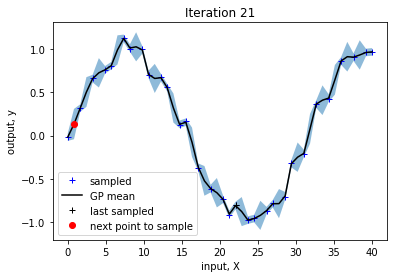

In [6]:
# define X domain and generate true labels
X = np.linspace(0, 40, num=50)
y = gen_true_data(X)
X = X.reshape(-1, 1)
# plt.plot(X,y,'o')
# plt.ylabel('output, y')
# plt.xlabel('input, X')

# sample 20 points initially
initial_N = 10
prev_idx = np.random.choice(np.arange(X.size),initial_N, replace=False)
print("initial sampled indices:",sorted(prev_idx))
print("initial sampled X's:",X[sorted(prev_idx)].reshape(-1))

df_init = pd.DataFrame({
    'X':X[prev_idx].reshape(-1),
    'y':y[prev_idx]
    })
df_init.to_csv('initial_xy.csv',index=False)
    


next_idx, gp_obj, scaler = GP_sampler(X, y, prev_idx)


#number of AL iterations
iterations = 21

sampled_dict = {
    'iteration': [0],
    'indices': [next_idx],
    'X': list(X[next_idx]),
    'y': [y[next_idx]]
}


df_iters = []

for i in range(iterations):
    next_idx_old = next_idx.copy()
    
    prev_idx = np.setxor1d(prev_idx, np.array([next_idx]))
    next_idx, gp_obj, scaler = GP_sampler(X,y, prev_idx)
    
    sampled_dict['iteration'].append(i+1)
    sampled_dict['indices'].append(next_idx)
    sampled_dict['X'].append(X[next_idx][0])
    sampled_dict['y'].append(y[next_idx])
    # plot sampled points
    plt.figure()
    plt.plot(X[prev_idx], y[prev_idx],'b+')

    
    
    # plot GP mean
    pred_mean, pred_std = gp_obj.predict(scaler.transform(X), return_std=True)
    plt.plot(X, pred_mean, 'k-')
    plt.fill_between(X.reshape(-1), pred_mean-pred_std*1.96, pred_mean+pred_std*1.96, alpha=0.5)
    
    
    df_iter = pd.DataFrame({
        'iteration': [i+1]*len(pred_mean),
        'X': X.reshape(-1),
        'pred': pred_mean,
        'CI_low': pred_mean-pred_std*1.96,
        'CI_high': pred_mean+pred_std*1.96
    })
    
    df_iter.to_csv('predictions_iter'+str(i+1)+'.csv', index=False)
    
    df_iters.append(df_iter)
    # plot last sampled point
    plt.plot(X[next_idx_old], y[next_idx_old],'k+')
    

    # plot next point
    plt.plot(X[next_idx], pred_mean[next_idx],'ro')
    
    # axis config
    plt.title('Iteration '+str(i+1))
    plt.xlabel("input, X")
    plt.ylabel("output, y")
    plt.legend(['sampled', 'GP mean', 'last sampled','next point to sample'])

    
pd.DataFrame(sampled_dict).to_csv('next_samples.csv',index=False)
# print(df_iter)
df_iters = pd.concat(df_iters)
df_iters.to_csv('predictions_all.csv', index=False)